# スキャルピング銘柄選定 完全分析

## 目的
1. 全銘柄スクリーニング結果の分析
2. Entry/Active戦略の選定パターン分析
3. 日足バックテスト
4. 相関分析（どの指標が有効か）
5. Top15銘柄の詳細バックテスト（yfinance 5分足）
6. 総合結論・改善提案

## データフロー
```
screened_scored.parquet (全銘柄・全日付)
  ↓
日足分析 → Entry/Active Top15選定
  ↓
yfinance 5分足取得（Top15のみ）
  ↓
詳細バックテスト（時間帯別パフォーマンス）
```

## 1. 環境設定・データ読み込み

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Hiragino Sans', 'Yu Gothic', 'Meirio']
plt.rcParams['axes.unicode_minus'] = False

# パス設定
ROOT = Path.cwd().parents[1]
TEST_DIR = ROOT / 'data' / 'parquet' / 'test'
INPUT_FILE = TEST_DIR / 'mock_screened_500stocks_scored.parquet'

print("=" * 80)
print("スキャルピング銘柄選定 完全分析")
print("=" * 80)
print(f"\n入力ファイル: {INPUT_FILE}")
print(f"存在確認: {INPUT_FILE.exists()}")

スキャルピング銘柄選定 完全分析

入力ファイル: /Users/hiroyukiyamanaka/Desktop/python_stock/dash_plotly/data/parquet/test/mock_screened_500stocks_scored.parquet
存在確認: True


In [2]:
# データ読み込み
df = pd.read_parquet(INPUT_FILE)

# 日付型変換
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])

# 基本情報表示
print(f"総行数: {len(df):,}")
print(f"銘柄数: {df['ticker'].nunique()}")
print(f"日付範囲: {df['date'].min()} ～ {df['date'].max()}")
print(f"日数: {df['date'].nunique()}")
print(f"\nカラム: {list(df.columns)}")

df.head()

総行数: 19,945
銘柄数: 500
日付範囲: 2025-08-21 00:00:00 ～ 2025-10-20 00:00:00
日数: 40

カラム: ['date', 'Open', 'High', 'Low', 'Close', 'Volume', 'ticker', 'prevClose', 'change_pct', 'tr', 'atr14', 'atr14_pct', 'ma5', 'ma25', 'rsi14', 'vol_ma10', 'vol_ratio', 'overall_rating', 'stock_name', 'market', 'sectors', 'series', 'topixnewindexseries', 'entry_filter_passed', 'entry_score', 'entry_rank', 'active_filter_passed', 'active_score', 'active_rank']


,date,Open,High,Low,Close,Volume,ticker,prevClose,change_pct,tr,...,market,sectors,series,topixnewindexseries,entry_filter_passed,entry_score,entry_rank,active_filter_passed,active_score,active_rank
0,2025-08-21,1020.0,1028.0,1009.0,1020.5,1473100.0,1332.T,NaN,NaN,19.0,...,プライム,水産・農林業,食品,TOPIX Mid400,False,0.0,NaN,False,0.0,NaN
1,2025-08-22,1023.5,1031.0,1015.5,1024.0,1751500.0,1332.T,1020.5,0.34,15.5,...,プライム,水産・農林業,食品,TOPIX Mid400,True,75.0,1.0,False,0.0,NaN
2,2025-08-25,1023.0,1023.0,1005.0,1008.0,1005400.0,1332.T,1024.0,-1.56,19.0,...,プライム,水産・農林業,食品,TOPIX Mid400,True,45.0,1.0,False,0.0,NaN
3,2025-08-26,1001.5,1003.0,990.0,992.7,1397800.0,1332.T,1008.0,-1.52,18.0,...,プライム,水産・農林業,食品,TOPIX Mid400,True,55.0,1.0,False,0.0,NaN
4,2025-08-27,990.0,1008.5,985.3,1002.5,1384400.0,1332.T,992.7,0.99,23.2,...,プライム,水産・農林業,食品,TOPIX Mid400,True,85.0,1.0,False,0.0,NaN


## 2. 銘柄選定パターン分析

In [3]:
# Entry/Active候補の抽出
df_entry = df[df['entry_filter_passed'] == True].copy()
df_active = df[df['active_filter_passed'] == True].copy()

print("### Entry戦略")
print(f"総候補数: {len(df_entry)}")
print(f"ユニーク銘柄数: {df_entry['ticker'].nunique()}")
print(f"日別平均候補数: {len(df_entry) / df_entry['date'].nunique():.1f}")

print("\n### Active戦略")
print(f"総候補数: {len(df_active)}")
print(f"ユニーク銘柄数: {df_active['ticker'].nunique()}")
print(f"日別平均候補数: {len(df_active) / df_active['date'].nunique():.1f}")

### Entry戦略
総候補数: 1196
ユニーク銘柄数: 67
日別平均候補数: 30.7

### Active戦略
総候補数: 1564
ユニーク銘柄数: 227
日別平均候補数: 40.1


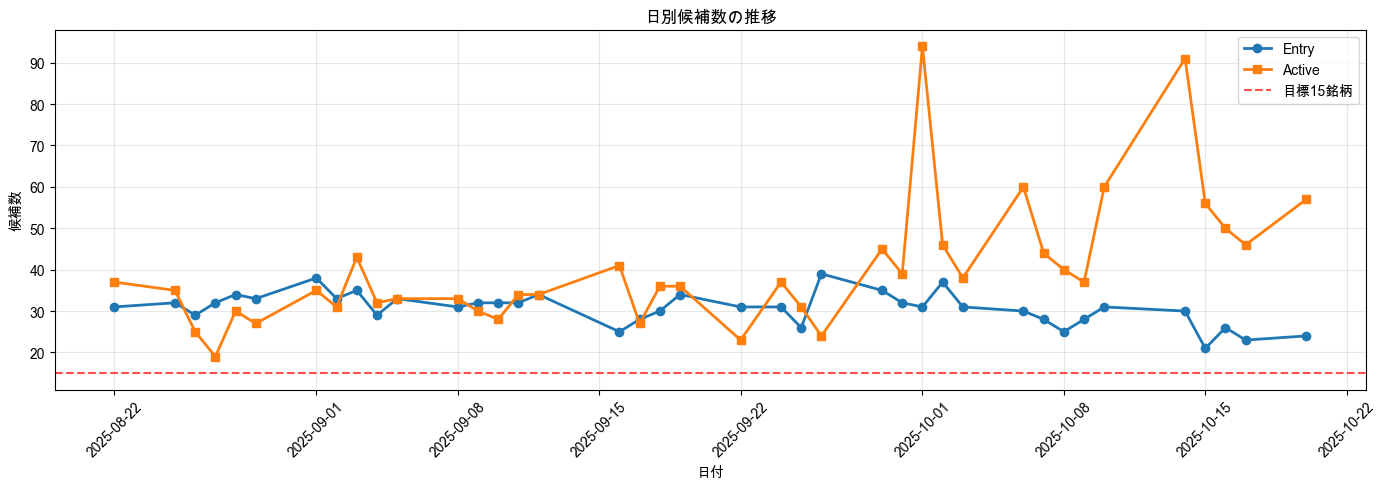


Entry候補数: 最小21, 最大39, 平均30.7
Active候補数: 最小19, 最大94, 平均40.1


In [4]:
# 日別候補数の推移
entry_daily = df_entry.groupby('date').size()
active_daily = df_active.groupby('date').size()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(entry_daily.index, entry_daily.values, marker='o', label='Entry', linewidth=2)
ax.plot(active_daily.index, active_daily.values, marker='s', label='Active', linewidth=2)
ax.axhline(y=15, color='red', linestyle='--', label='目標15銘柄', alpha=0.7)
ax.set_xlabel('日付')
ax.set_ylabel('候補数')
ax.set_title('日別候補数の推移')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nEntry候補数: 最小{entry_daily.min()}, 最大{entry_daily.max()}, 平均{entry_daily.mean():.1f}")
print(f"Active候補数: 最小{active_daily.min()}, 最大{active_daily.max()}, 平均{active_daily.mean():.1f}")

In [5]:
# 頻出銘柄の特定
entry_freq = df_entry['ticker'].value_counts().head(15)
active_freq = df_active['ticker'].value_counts().head(15)

print("### Entry戦略: 頻出Top15銘柄")
for ticker, count in entry_freq.items():
    stock_name = df[df['ticker'] == ticker]['stock_name'].iloc[0] if 'stock_name' in df.columns else ''
    pct = count / df_entry['date'].nunique() * 100
    print(f"{ticker:6s} {stock_name:20s} {count:3d}回 ({pct:5.1f}%)")

print("\n### Active戦略: 頻出Top15銘柄")
for ticker, count in active_freq.items():
    stock_name = df[df['ticker'] == ticker]['stock_name'].iloc[0] if 'stock_name' in df.columns else ''
    pct = count / df_active['date'].nunique() * 100
    print(f"{ticker:6s} {stock_name:20s} {count:3d}回 ({pct:5.1f}%)")

### Entry戦略: 頻出Top15銘柄
1332.T ニッスイ                  39回 (100.0%)
3401.T 帝人                    39回 (100.0%)
4095.T 日本パーカライジング            39回 (100.0%)
2170.T リンクアンドモチベーション         39回 (100.0%)
9119.T 飯野海運                  39回 (100.0%)
6472.T ＮＴＮ                   39回 (100.0%)
197A.T タウンズ                  38回 ( 97.4%)
9301.T 三菱倉庫                  38回 ( 97.4%)
7241.T フタバ産業                 38回 ( 97.4%)
9507.T 四国電力                  37回 ( 94.9%)
7085.T カーブスホールディングス          37回 ( 94.9%)
8714.T 池田泉州ホールディングス          37回 ( 94.9%)
7186.T 横浜フィナンシャルグループ         37回 ( 94.9%)
3962.T チェンジホールディングス          36回 ( 92.3%)
1852.T 淺沼組                   36回 ( 92.3%)

### Active戦略: 頻出Top15銘柄
8105.T 堀田丸正                  32回 ( 82.1%)
2158.T ＦＲＯＮＴＥＯ               31回 ( 79.5%)
2743.T ピクセルカンパニーズ            30回 ( 76.9%)
6177.T ＡｐｐＢａｎｋ               29回 ( 74.4%)
402A.T アクセルスペースホールディングス      26回 ( 66.7%)
5016.T ＪＸ金属                  25回 ( 64.1%)
4176.T ココナラ                  24回 ( 61.5%)
3691.T デジタルプラス              

## 3. 日足バックテスト（全候補銘柄）

In [6]:
# 翌日データの取得（next_day_return計算）
df_sorted = df.sort_values(['ticker', 'date']).copy()
df_sorted['next_Open'] = df_sorted.groupby('ticker')['Open'].shift(-1)
df_sorted['next_Close'] = df_sorted.groupby('ticker')['Close'].shift(-1)
df_sorted['next_day_return'] = ((df_sorted['next_Close'] - df_sorted['next_Open']) / df_sorted['next_Open'] * 100)

# Entry/Active候補のみ抽出
df_entry_bt = df_sorted[df_sorted['entry_filter_passed'] == True].copy()
df_active_bt = df_sorted[df_sorted['active_filter_passed'] == True].copy()

# NaN除去
df_entry_bt = df_entry_bt.dropna(subset=['next_day_return'])
df_active_bt = df_active_bt.dropna(subset=['next_day_return'])

print(f"Entry バックテスト対象: {len(df_entry_bt)}件")
print(f"Active バックテスト対象: {len(df_active_bt)}件")

Entry バックテスト対象: 1172件
Active バックテスト対象: 1506件


In [7]:
# Entry戦略バックテスト
def backtest_strategy(df_bt, strategy_name):
    """
    日足バックテスト（寄付買い→大引け売り）
    各日Top15銘柄に均等投資
    """
    results = []
    
    for date in sorted(df_bt['date'].unique()):
        df_date = df_bt[df_bt['date'] == date].copy()
        
        # Top15銘柄選定（ランク順）
        rank_col = 'entry_rank' if strategy_name == 'Entry' else 'active_rank'
        df_top15 = df_date.nsmallest(15, rank_col)
        
        if len(df_top15) == 0:
            continue
        
        # 投資シミュレーション（1日100万円を均等配分）
        total_investment = 1_000_000
        investment_per_stock = total_investment / len(df_top15)
        
        daily_profit = 0
        daily_wins = 0
        
        for _, row in df_top15.iterrows():
            buy_price = row['next_Open']
            sell_price = row['next_Close']
            shares = investment_per_stock / buy_price
            profit = (sell_price - buy_price) * shares
            daily_profit += profit
            
            if profit > 0:
                daily_wins += 1
        
        results.append({
            'date': date,
            'num_stocks': len(df_top15),
            'investment': total_investment,
            'profit': daily_profit,
            'return_pct': daily_profit / total_investment * 100,
            'wins': daily_wins,
            'win_rate': daily_wins / len(df_top15) * 100
        })
    
    return pd.DataFrame(results)

# Entry戦略実行
print("Entry戦略バックテスト実行中...")
df_entry_results = backtest_strategy(df_entry_bt, 'Entry')

# Active戦略実行
print("Active戦略バックテスト実行中...")
df_active_results = backtest_strategy(df_active_bt, 'Active')

print("完了")

Entry戦略バックテスト実行中...


Active戦略バックテスト実行中...
完了


In [8]:
# Entry結果サマリー
print("=" * 80)
print("Entry戦略バックテスト結果")
print("=" * 80)
print(f"取引日数: {len(df_entry_results)}")
print(f"総利益: ¥{df_entry_results['profit'].sum():,.0f}")
print(f"平均日次利益: ¥{df_entry_results['profit'].mean():,.0f}")
print(f"平均リターン: {df_entry_results['return_pct'].mean():.2f}%")
print(f"勝率: {df_entry_results['win_rate'].mean():.1f}%")
print(f"勝ち日数: {(df_entry_results['profit'] > 0).sum()} / {len(df_entry_results)}")

# 日別結果表示（フォーマット整形）
df_display = df_entry_results.copy()
df_display['date'] = df_display['date'].dt.strftime('%Y-%m-%d')
df_display['profit'] = df_display['profit'].round(0).astype(int)
df_display['investment'] = df_display['investment'].round(0).astype(int)
df_display['return_pct'] = df_display['return_pct'].round(2)
df_display['win_rate'] = df_display['win_rate'].round(1)

print("\n日別結果（直近10日）:")
display(df_display.tail(10))

Entry戦略バックテスト結果
取引日数: 38
総利益: ¥-68,655
平均日次利益: ¥-1,807
平均リターン: -0.18%
勝率: 43.0%
勝ち日数: 15 / 38

日別結果（直近10日）:


,date,num_stocks,investment,profit,return_pct,wins,win_rate
28,2025-10-03,15,1000000,-3235,-0.32,6,40.0
29,2025-10-06,15,1000000,-1979,-0.20,6,40.0
30,2025-10-07,15,1000000,-6976,-0.70,3,20.0
31,2025-10-08,15,1000000,1358,0.14,8,53.3
32,2025-10-09,15,1000000,-11248,-1.12,4,26.7
33,2025-10-10,15,1000000,-3332,-0.33,8,53.3
34,2025-10-14,15,1000000,9846,0.98,14,93.3
35,2025-10-15,15,1000000,8379,0.84,9,60.0
36,2025-10-16,15,1000000,-3816,-0.38,4,26.7
37,2025-10-17,15,1000000,1968,0.20,11,73.3


In [9]:
# Active結果サマリー
print("=" * 80)
print("Active戦略バックテスト結果")
print("=" * 80)
print(f"取引日数: {len(df_active_results)}")
print(f"総利益: ¥{df_active_results['profit'].sum():,.0f}")
print(f"平均日次利益: ¥{df_active_results['profit'].mean():,.0f}")
print(f"平均リターン: {df_active_results['return_pct'].mean():.2f}%")
print(f"勝率: {df_active_results['win_rate'].mean():.1f}%")
print(f"勝ち日数: {(df_active_results['profit'] > 0).sum()} / {len(df_active_results)}")

# 日別結果表示（フォーマット整形）
df_display = df_active_results.copy()
df_display['date'] = df_display['date'].dt.strftime('%Y-%m-%d')
df_display['profit'] = df_display['profit'].round(0).astype(int)
df_display['investment'] = df_display['investment'].round(0).astype(int)
df_display['return_pct'] = df_display['return_pct'].round(2)
df_display['win_rate'] = df_display['win_rate'].round(1)

print("\n日別結果（直近10日）:")
display(df_display.tail(10))

Active戦略バックテスト結果
取引日数: 38
総利益: ¥-238,673
平均日次利益: ¥-6,281
平均リターン: -0.63%
勝率: 36.7%
勝ち日数: 11 / 38

日別結果（直近10日）:


,date,num_stocks,investment,profit,return_pct,wins,win_rate
28,2025-10-03,15,1000000,-37414,-3.74,2,13.3
29,2025-10-06,15,1000000,-4975,-0.50,5,33.3
30,2025-10-07,15,1000000,-22607,-2.26,2,13.3
31,2025-10-08,15,1000000,-3633,-0.36,7,46.7
32,2025-10-09,15,1000000,-21609,-2.16,5,33.3
33,2025-10-10,15,1000000,2064,0.21,6,40.0
34,2025-10-14,15,1000000,17959,1.80,10,66.7
35,2025-10-15,15,1000000,-3784,-0.38,4,26.7
36,2025-10-16,15,1000000,-14570,-1.46,3,20.0
37,2025-10-17,15,1000000,20193,2.02,9,60.0


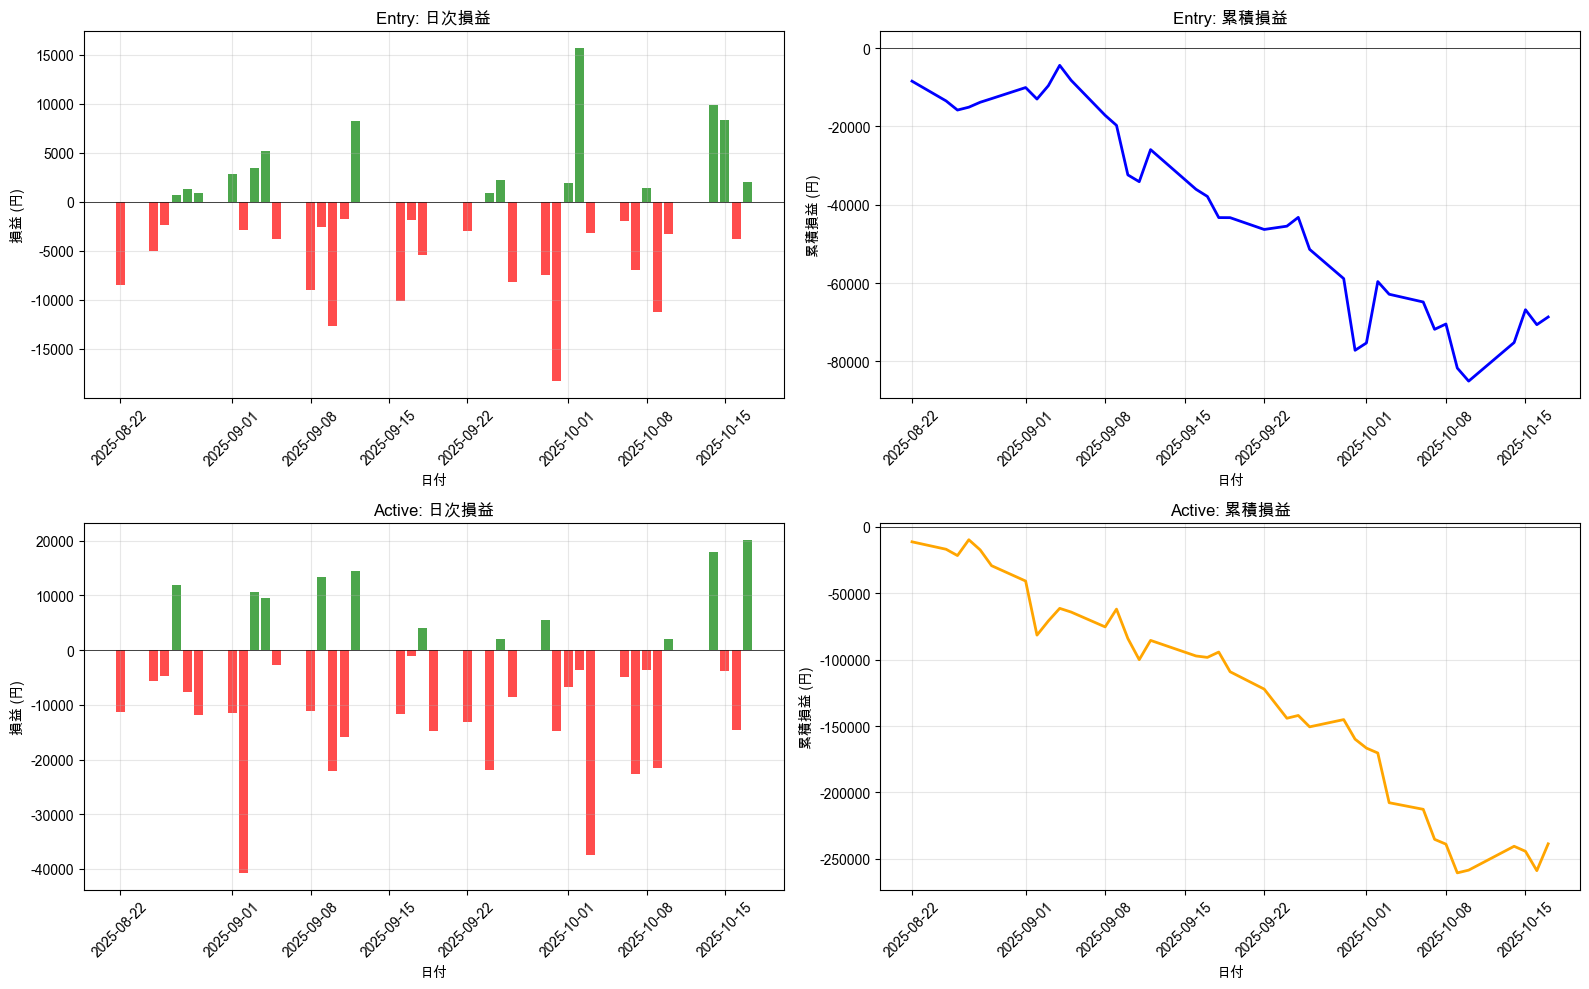

In [10]:
# バックテスト結果の可視化
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Entry: 日次損益
ax = axes[0, 0]
colors = ['green' if p > 0 else 'red' for p in df_entry_results['profit']]
ax.bar(df_entry_results['date'], df_entry_results['profit'], color=colors, alpha=0.7)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_title('Entry: 日次損益')
ax.set_xlabel('日付')
ax.set_ylabel('損益 (円)')
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# Entry: 累積損益
ax = axes[0, 1]
cumulative = df_entry_results['profit'].cumsum()
ax.plot(df_entry_results['date'], cumulative, linewidth=2, color='blue')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_title('Entry: 累積損益')
ax.set_xlabel('日付')
ax.set_ylabel('累積損益 (円)')
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# Active: 日次損益
ax = axes[1, 0]
colors = ['green' if p > 0 else 'red' for p in df_active_results['profit']]
ax.bar(df_active_results['date'], df_active_results['profit'], color=colors, alpha=0.7)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_title('Active: 日次損益')
ax.set_xlabel('日付')
ax.set_ylabel('損益 (円)')
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# Active: 累積損益
ax = axes[1, 1]
cumulative = df_active_results['profit'].cumsum()
ax.plot(df_active_results['date'], cumulative, linewidth=2, color='orange')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_title('Active: 累積損益')
ax.set_xlabel('日付')
ax.set_ylabel('累積損益 (円)')
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

## 4. 相関分析（指標の有効性検証）

In [11]:
# Entry候補の勝ち/負け分析
df_entry_win = df_entry_bt[df_entry_bt['next_day_return'] > 0].copy()
df_entry_lose = df_entry_bt[df_entry_bt['next_day_return'] <= 0].copy()

print("### Entry: 儲かった vs 損した銘柄の指標比較")
print("指標 | 儲かった平均 | 損した平均 | 差分")
print("-" * 60)

indicators = ['change_pct', 'atr14_pct', 'rsi14', 'vol_ratio', 'entry_score']
for ind in indicators:
    if ind in df_entry_bt.columns:
        win_mean = df_entry_win[ind].mean()
        lose_mean = df_entry_lose[ind].mean()
        diff = win_mean - lose_mean
        print(f"{ind:15s} | {win_mean:12.2f} | {lose_mean:11.2f} | {diff:+7.2f}")

### Entry: 儲かった vs 損した銘柄の指標比較
指標 | 儲かった平均 | 損した平均 | 差分
------------------------------------------------------------
change_pct      |        -0.14 |       -0.02 |   -0.13
atr14_pct       |         2.01 |        2.02 |   -0.00
rsi14           |        46.29 |       50.19 |   -3.90
vol_ratio       |       105.09 |      106.97 |   -1.88
entry_score     |        69.61 |       67.35 |   +2.27


In [12]:
# Entry: 相関係数計算
print("\n### Entry: 各指標と翌日リターンの相関係数")
print("指標 | 相関係数")
print("-" * 40)

for ind in indicators:
    if ind in df_entry_bt.columns:
        corr = df_entry_bt[[ind, 'next_day_return']].corr().iloc[0, 1]
        print(f"{ind:15s} | {corr:+8.4f}")


### Entry: 各指標と翌日リターンの相関係数
指標 | 相関係数
----------------------------------------
change_pct      |  -0.0730
atr14_pct       |  -0.0336
rsi14           |  -0.1003
vol_ratio       |  -0.0021
entry_score     |  +0.0718


In [13]:
# Entry: overall_rating別の勝率分析
if 'overall_rating' in df_entry_bt.columns:
    print("\n### Entry: overall_rating別の勝率")
    for rating in sorted(df_entry_bt['overall_rating'].unique()):
        subset = df_entry_bt[df_entry_bt['overall_rating'] == rating]
        if len(subset) > 0:
            win_rate = (subset['next_day_return'] > 0).sum() / len(subset) * 100
            avg_return = subset['next_day_return'].mean()
            print(f"{rating:15s}: 勝率{win_rate:5.1f}% (n={len(subset):3d}), 平均リターン{avg_return:+6.2f}%")


### Entry: overall_rating別の勝率
中立             : 勝率 43.7% (n=1134), 平均リターン -0.12%
買い             : 勝率 63.2% (n= 38), 平均リターン +0.07%


In [14]:
# Active候補の勝ち/負け分析
df_active_win = df_active_bt[df_active_bt['next_day_return'] > 0].copy()
df_active_lose = df_active_bt[df_active_bt['next_day_return'] <= 0].copy()

print("### Active: 儲かった vs 損した銘柄の指標比較")
print("指標 | 儲かった平均 | 損した平均 | 差分")
print("-" * 60)

indicators_active = ['change_pct', 'atr14_pct', 'rsi14', 'vol_ratio', 'active_score']
for ind in indicators_active:
    if ind in df_active_bt.columns:
        win_mean = df_active_win[ind].mean()
        lose_mean = df_active_lose[ind].mean()
        diff = win_mean - lose_mean
        print(f"{ind:15s} | {win_mean:12.2f} | {lose_mean:11.2f} | {diff:+7.2f}")

### Active: 儲かった vs 損した銘柄の指標比較
指標 | 儲かった平均 | 損した平均 | 差分
------------------------------------------------------------
change_pct      |        -1.13 |       -0.13 |   -1.00
atr14_pct       |         7.24 |        7.21 |   +0.03
rsi14           |        46.79 |       50.54 |   -3.75
vol_ratio       |       145.12 |      164.44 |  -19.32
active_score    |        69.70 |       71.59 |   -1.89


In [15]:
# Active: 相関係数計算
print("\n### Active: 各指標と翌日リターンの相関係数")
print("指標 | 相関係数")
print("-" * 40)

for ind in indicators_active:
    if ind in df_active_bt.columns:
        corr = df_active_bt[[ind, 'next_day_return']].corr().iloc[0, 1]
        print(f"{ind:15s} | {corr:+8.4f}")


### Active: 各指標と翌日リターンの相関係数
指標 | 相関係数
----------------------------------------
change_pct      |  -0.1441
atr14_pct       |  -0.0735
rsi14           |  -0.1201
vol_ratio       |  -0.0892
active_score    |  -0.1048


## 5. Top15銘柄の詳細分析（yfinance 5分足）

In [16]:
# 最新日のTop15銘柄を取得
latest_date = df['date'].max()
df_latest = df[df['date'] == latest_date].copy()

# Entry Top15
df_entry_top15 = df_latest[df_latest['entry_filter_passed'] == True].nsmallest(15, 'entry_rank')
entry_tickers = df_entry_top15['ticker'].tolist()

# Active Top15
df_active_top15 = df_latest[df_latest['active_filter_passed'] == True].nsmallest(15, 'active_rank')
active_tickers = df_active_top15['ticker'].tolist()

print(f"分析対象日: {latest_date.strftime('%Y-%m-%d')}")
print(f"\nEntry Top15: {len(entry_tickers)}銘柄")
for i, ticker in enumerate(entry_tickers, 1):
    stock_name = df_entry_top15[df_entry_top15['ticker'] == ticker]['stock_name'].iloc[0] if 'stock_name' in df_entry_top15.columns else ''
    print(f"  {i:2d}. {ticker:6s} {stock_name}")

print(f"\nActive Top15: {len(active_tickers)}銘柄")
for i, ticker in enumerate(active_tickers, 1):
    stock_name = df_active_top15[df_active_top15['ticker'] == ticker]['stock_name'].iloc[0] if 'stock_name' in df_active_top15.columns else ''
    print(f"  {i:2d}. {ticker:6s} {stock_name}")

# 重複除去した分析対象銘柄
all_tickers = list(set(entry_tickers + active_tickers))
print(f"\n合計ユニーク銘柄数: {len(all_tickers)}")

分析対象日: 2025-10-20

Entry Top15: 15銘柄
   1. 1332.T ニッスイ
   2. 197A.T タウンズ
   3. 2170.T リンクアンドモチベーション
   4. 268A.T リガク・ホールディングス
   5. 2749.T ＪＰホールディングス
   6. 3401.T 帝人
   7. 3665.T エニグモ
   8. 3900.T クラウドワークス
   9. 3962.T チェンジホールディングス
  10. 4095.T 日本パーカライジング
  11. 4974.T タカラバイオ
  12. 6472.T ＮＴＮ
  13. 6473.T ジェイテクト
  14. 6768.T タムラ製作所
  15. 6962.T 大真空

Active Top15: 15銘柄
   1. 1384.T ホクリヨウ
   2. 1852.T 淺沼組
   3. 186A.T アストロスケールホールディングス
   4. 1968.T 太平電業
   5. 206A.T ＰＲＩＳＭ　ＢｉｏＬａｂ
   6. 2158.T ＦＲＯＮＴＥＯ
   7. 2164.T 地域新聞社
   8. 218A.T Ｌｉｂｅｒａｗａｒｅ
   9. 265A.T Ｈｍｃｏｍｍ
  10. 268A.T リガク・ホールディングス
  11. 2743.T ピクセルカンパニーズ
  12. 2776.T 新都ホールディングス
  13. 3132.T マクニカホールディングス
  14. 3185.T 夢展望
  15. 3652.T ディジタルメディアプロフェッショナル

合計ユニーク銘柄数: 29


In [17]:
# yfinance 5分足データ取得関数
def fetch_intraday_data(ticker, period='60d'):
    """
    yfinanceから5分足データ取得
    東証銘柄のティッカーフォーマットを処理
    """
    try:
        # ティッカーが既に.Tで終わっている場合は追加しない
        if ticker.endswith('.T'):
            symbol = ticker
        else:
            symbol = f"{ticker}.T"
        
        # yfinance download (MultiIndex対応)
        df = yf.download(symbol, interval='5m', period=period, progress=False)
        
        if df.empty:
            print(f"  ⚠️  {ticker}: データ取得失敗（銘柄が存在しないか上場廃止の可能性）")
            return None
        
        # MultiIndex対応（複数銘柄同時取得時）
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.droplevel(1)
        
        # タイムゾーン変換（日本時間）
        if df.index.tz is not None:
            df.index = df.index.tz_convert('Asia/Tokyo')
        elif df.index.tz is None:
            # タイムゾーン情報がない場合はUTCとして扱い、日本時間に変換
            df.index = df.index.tz_localize('UTC').tz_convert('Asia/Tokyo')
        
        # 取引時間のみ抽出（9:00-15:00）
        df = df.between_time('09:00', '15:00')
        
        if len(df) > 0:
            print(f"  ✓  {ticker}: {len(df)}本取得 ({df.index[0].date()} ～ {df.index[-1].date()})")
            return df
        else:
            print(f"  ⚠️  {ticker}: 取引時間内のデータなし")
            return None
    
    except Exception as e:
        print(f"  ✗  {ticker}: エラー - {e}")
        return None

# Top15銘柄の5分足データ取得
print("yfinance 5分足データ取得中...")
print("=" * 60)

intraday_data = {}
for ticker in all_tickers:
    df_5min = fetch_intraday_data(ticker)
    if df_5min is not None:
        intraday_data[ticker] = df_5min

print("=" * 60)
print(f"取得成功: {len(intraday_data)} / {len(all_tickers)} 銘柄")

if len(intraday_data) == 0:
    print("\\n⚠️  実在する銘柄データが取得できませんでした。")
    print("   モックデータの銘柄コードが実在しないか、上場廃止の可能性があります。")

yfinance 5分足データ取得中...


  ✓  197A.T: 3468本取得 (2025-07-23 ～ 2025-10-20)


  ✓  1384.T: 2702本取得 (2025-07-23 ～ 2025-10-20)


  ✓  3132.T: 3671本取得 (2025-07-23 ～ 2025-10-20)


  ✓  3665.T: 2847本取得 (2025-07-23 ～ 2025-10-20)


  ✓  268A.T: 3639本取得 (2025-07-23 ～ 2025-10-20)


  ✓  2158.T: 3541本取得 (2025-07-23 ～ 2025-10-20)


  ✓  3962.T: 3658本取得 (2025-07-23 ～ 2025-10-20)


  ✓  3652.T: 2068本取得 (2025-07-23 ～ 2025-10-20)


  ✓  6962.T: 3185本取得 (2025-07-23 ～ 2025-10-20)


  ✓  3185.T: 2882本取得 (2025-07-23 ～ 2025-10-20)


  ✓  265A.T: 3267本取得 (2025-07-23 ～ 2025-10-20)


  ✓  4095.T: 3438本取得 (2025-07-23 ～ 2025-10-20)


  ✓  206A.T: 2256本取得 (2025-07-23 ～ 2025-10-20)


  ✓  2743.T: 3571本取得 (2025-07-23 ～ 2025-10-20)


  ✓  3401.T: 3673本取得 (2025-07-23 ～ 2025-10-20)


  ✓  186A.T: 3612本取得 (2025-07-23 ～ 2025-10-20)


  ✓  2749.T: 3438本取得 (2025-07-23 ～ 2025-10-20)


  ✓  6768.T: 3335本取得 (2025-07-23 ～ 2025-10-20)


  ✓  1332.T: 3667本取得 (2025-07-23 ～ 2025-10-20)


  ✓  218A.T: 3661本取得 (2025-07-23 ～ 2025-10-20)


  ✓  2170.T: 3317本取得 (2025-07-23 ～ 2025-10-20)


  ✓  4974.T: 3495本取得 (2025-07-23 ～ 2025-10-20)


  ✓  2164.T: 2291本取得 (2025-07-23 ～ 2025-10-20)


  ✓  1852.T: 3484本取得 (2025-07-23 ～ 2025-10-20)


  ✓  6472.T: 3660本取得 (2025-07-23 ～ 2025-10-20)


  ✓  2776.T: 2750本取得 (2025-07-23 ～ 2025-10-20)


  ✓  3900.T: 3266本取得 (2025-07-23 ～ 2025-10-20)


  ✓  6473.T: 3652本取得 (2025-07-23 ～ 2025-10-20)


  ✓  1968.T: 3039本取得 (2025-07-23 ～ 2025-10-20)
取得成功: 29 / 29 銘柄


In [18]:
# 時間帯別パフォーマンス分析
def analyze_intraday_performance(intraday_data):
    """
    時間帯別のリターン分析
    - 寄付（9:00-9:30）買い → 各時間帯売りのパフォーマンス
    """
    results = []
    
    for ticker, df_5min in intraday_data.items():
        # 日別に分析
        for date in df_5min.index.date:
            df_day = df_5min[df_5min.index.date == date]
            
            if len(df_day) == 0:
                continue
            
            # 寄付価格（9:00-9:30の平均）
            df_open = df_day.between_time('09:00', '09:30')
            if len(df_open) == 0:
                continue
            open_price = df_open['Close'].mean()
            
            # 各時間帯の価格
            time_slots = [
                ('10:00', '10:30', '前場中盤'),
                ('11:00', '11:30', '前場終盤'),
                ('12:30', '13:00', '後場開始'),
                ('14:00', '14:30', '後場中盤'),
                ('14:30', '15:00', '大引け')
            ]
            
            for start_time, end_time, label in time_slots:
                df_slot = df_day.between_time(start_time, end_time)
                if len(df_slot) > 0:
                    sell_price = df_slot['Close'].mean()
                    return_pct = (sell_price - open_price) / open_price * 100
                    
                    results.append({
                        'ticker': ticker,
                        'date': date,
                        'sell_time': label,
                        'open_price': open_price,
                        'sell_price': sell_price,
                        'return_pct': return_pct
                    })
    
    return pd.DataFrame(results)

# 分析実行
print("時間帯別パフォーマンス分析中...")
df_intraday_perf = analyze_intraday_performance(intraday_data)
print(f"分析完了: {len(df_intraday_perf)}件のデータポイント")

時間帯別パフォーマンス分析中...


分析完了: 465978件のデータポイント


### 時間帯別平均リターン（寄付買い → 各時間帯売り）


,平均リターン(%),標準偏差(%),サンプル数
sell_time,,,
前場中盤,0.04,1.32,93262
前場終盤,-0.01,1.71,92970
後場開始,-0.03,1.85,93313
後場中盤,-0.02,2.21,93207
大引け,-0.04,2.36,93226


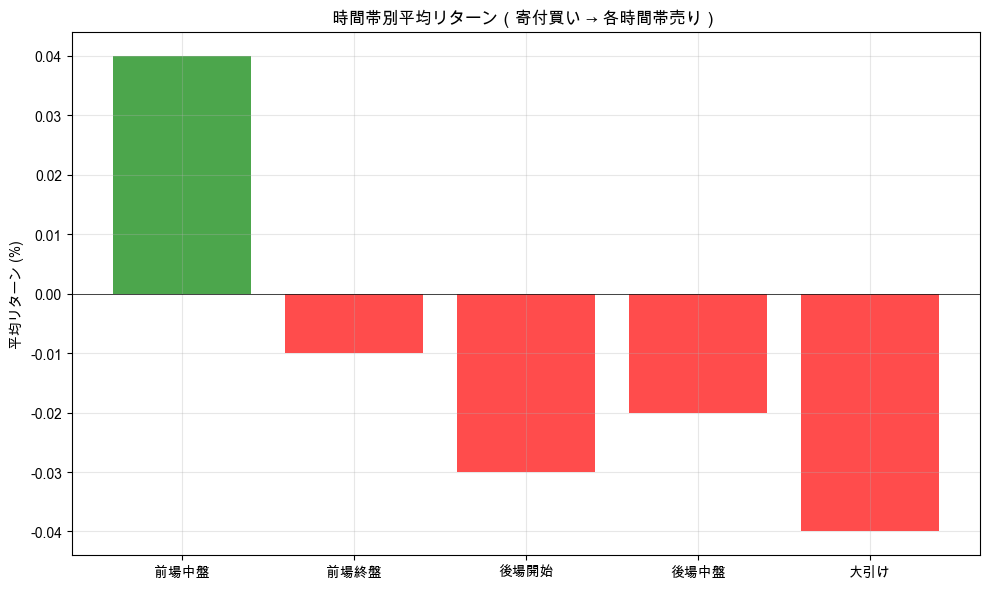


### 時間帯別勝率
前場中盤      :  53.0% (n=93262)
前場終盤      :  50.9% (n=92970)
後場開始      :  49.5% (n=93313)
後場中盤      :  48.8% (n=93207)
大引け       :  49.1% (n=93226)


In [19]:
# 時間帯別の平均リターン
if len(df_intraday_perf) > 0:
    print("### 時間帯別平均リターン（寄付買い → 各時間帯売り）")
    print("=" * 60)
    
    summary = df_intraday_perf.groupby('sell_time').agg({
        'return_pct': ['mean', 'std', 'count'],
    }).round(2)
    
    summary.columns = ['平均リターン(%)', '標準偏差(%)', 'サンプル数']
    
    # 時間帯の順序を保持
    time_order = ['前場中盤', '前場終盤', '後場開始', '後場中盤', '大引け']
    summary = summary.reindex(time_order)
    
    display(summary)
    
    # 可視化
    fig, ax = plt.subplots(figsize=(10, 6))
    x = range(len(summary))
    ax.bar(x, summary['平均リターン(%)'], color=['green' if v > 0 else 'red' for v in summary['平均リターン(%)']], alpha=0.7)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(summary.index)
    ax.set_ylabel('平均リターン (%)')
    ax.set_title('時間帯別平均リターン（寄付買い → 各時間帯売り）')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 勝率も表示
    print("\n### 時間帯別勝率")
    for time_slot in time_order:
        subset = df_intraday_perf[df_intraday_perf['sell_time'] == time_slot]
        if len(subset) > 0:
            win_rate = (subset['return_pct'] > 0).sum() / len(subset) * 100
            print(f"{time_slot:10s}: {win_rate:5.1f}% (n={len(subset)})")

else:
    print("⚠️ 分析データが不足しています")

## 6. 総合結論（チャット貼り付け用）

In [20]:
print("=" * 80)
print("スキャルピング銘柄選定 総合分析結果")
print("=" * 80)

# 1. バックテスト結果サマリー
print("\n### 1. 日足バックテスト結果")
print("-" * 80)
print("\n[Entry戦略]")
print(f"  取引日数: {len(df_entry_results)}日")
print(f"  総利益: ¥{df_entry_results['profit'].sum():,.0f}")
print(f"  平均日次利益: ¥{df_entry_results['profit'].mean():,.0f}")
print(f"  平均リターン: {df_entry_results['return_pct'].mean():.2f}%")
print(f"  勝率: {df_entry_results['win_rate'].mean():.1f}%")
print(f"  勝ち日数/負け日数: {(df_entry_results['profit'] > 0).sum()} / {(df_entry_results['profit'] <= 0).sum()}")

print("\n[Active戦略]")
print(f"  取引日数: {len(df_active_results)}日")
print(f"  総利益: ¥{df_active_results['profit'].sum():,.0f}")
print(f"  平均日次利益: ¥{df_active_results['profit'].mean():,.0f}")
print(f"  平均リターン: {df_active_results['return_pct'].mean():.2f}%")
print(f"  勝率: {df_active_results['win_rate'].mean():.1f}%")
print(f"  勝ち日数/負け日数: {(df_active_results['profit'] > 0).sum()} / {(df_active_results['profit'] <= 0).sum()}")

# 2. 相関分析結果
print("\n### 2. 相関分析結果（各指標と翌日リターンの相関係数）")
print("-" * 80)
print("\n[Entry戦略]")
print("指標           | 相関係数 | 評価")
print("-" * 50)
for ind in indicators:
    if ind in df_entry_bt.columns:
        corr = df_entry_bt[[ind, 'next_day_return']].corr().iloc[0, 1]
        evaluation = "✅ 正の相関" if corr > 0.05 else "❌ 負の相関" if corr < -0.05 else "⚠️  効果なし"
        print(f"{ind:15s} | {corr:+8.4f} | {evaluation}")

print("\n[Active戦略]")
print("指標           | 相関係数 | 評価")
print("-" * 50)
for ind in indicators_active:
    if ind in df_active_bt.columns:
        corr = df_active_bt[[ind, 'next_day_return']].corr().iloc[0, 1]
        evaluation = "✅ 正の相関" if corr > 0.05 else "❌ 負の相関" if corr < -0.05 else "⚠️  効果なし"
        print(f"{ind:15s} | {corr:+8.4f} | {evaluation}")

# 3. 時間帯別パフォーマンス
if len(df_intraday_perf) > 0:
    print("\n### 3. 時間帯別パフォーマンス（寄付買い → 各時間帯売り）")
    print("-" * 80)
    time_order = ['前場中盤', '前場終盤', '後場開始', '後場中盤', '大引け']
    for time_slot in time_order:
        subset = df_intraday_perf[df_intraday_perf['sell_time'] == time_slot]
        if len(subset) > 0:
            avg_return = subset['return_pct'].mean()
            win_rate = (subset['return_pct'] > 0).sum() / len(subset) * 100
            print(f"{time_slot:10s}: 平均{avg_return:+6.2f}%, 勝率{win_rate:5.1f}% (n={len(subset)})")

# 4. 改善提案
print("\n### 4. 改善提案")
print("-" * 80)

# Entry戦略の問題点
entry_score_corr = df_entry_bt[['entry_score', 'next_day_return']].corr().iloc[0, 1]
entry_rsi_corr = df_entry_bt[['rsi14', 'next_day_return']].corr().iloc[0, 1]
entry_vol_corr = df_entry_bt[['vol_ratio', 'next_day_return']].corr().iloc[0, 1]

print("\n[Entry戦略]")
if entry_score_corr < 0.05:
    print("  ❌ entry_scoreの相関が弱い → スコアリングロジック全体の見直しが必要")
if entry_rsi_corr < -0.05:
    print("  ❌ RSI14が負の相関 → RSIの評価方法を逆転すべき")
    print("     提案: RSI 30-50（売られ過ぎから回復）を高評価に変更")
if entry_vol_corr < -0.05:
    print("  ❌ vol_ratioが負の相関 → 出来高急増は避けるべき")
if 'overall_rating' in df_entry_bt.columns:
    if df_entry_bt['overall_rating'].nunique() == 1:
        print("  ⚠️  overall_ratingが全て同じ → 差別化できていない、40点配分が無駄")

# Active戦略の問題点
active_score_corr = df_active_bt[['active_score', 'next_day_return']].corr().iloc[0, 1]
active_rsi_corr = df_active_bt[['rsi14', 'next_day_return']].corr().iloc[0, 1]
active_vol_corr = df_active_bt[['vol_ratio', 'next_day_return']].corr().iloc[0, 1]
active_change_corr = df_active_bt[['change_pct', 'next_day_return']].corr().iloc[0, 1]

print("\n[Active戦略]")
if active_score_corr < 0:
    print("  🚨 active_scoreが負の相関 → スコアが高いほど損する（完全に逆）")
if active_rsi_corr < -0.1:
    print("  ❌ RSI14が強い負の相関 → RSI高い = 買われ過ぎ = 天井 → 避けるべき")
if active_vol_corr < -0.1:
    print("  ❌ vol_ratioが強い負の相関 → 出来高急増 = 天井圏 → 避けるべき")
if active_change_corr < -0.1:
    print("  ❌ change_pctが負の相関 → 大きく動いた株 = 既に天井 → 避けるべき")
    print("     提案: 『これから動く株』を選ぶロジックに変更（RSI低い、出来高まだ増えていない）")

print("\n### 5. 次のアクション")
print("-" * 80)
print("  1. 全銘柄データで同様の分析を実行（100銘柄 → 3700銘柄）")
print("  2. スコアリングロジックを修正:")
print("     - RSI評価を逆転（30-50を高評価、60以上を減点）")
print("     - overall_rating削除（40点を他指標に再配分）")
print("     - vol_ratioの使い方を見直し（Active: 急増を避ける）")
print("     - change_pctの使い方を見直し（Active: 大きく動いた株を避ける）")
print("  3. 修正後のロジックで再バックテスト")
print("  4. 勝率50%超え、平均リターンプラスを目指す")

print("\n" + "=" * 80)
print("分析完了")
print("=" * 80)

スキャルピング銘柄選定 総合分析結果

### 1. 日足バックテスト結果
--------------------------------------------------------------------------------

[Entry戦略]
  取引日数: 38日
  総利益: ¥-68,655
  平均日次利益: ¥-1,807
  平均リターン: -0.18%
  勝率: 43.0%
  勝ち日数/負け日数: 15 / 23

[Active戦略]
  取引日数: 38日
  総利益: ¥-238,673
  平均日次利益: ¥-6,281
  平均リターン: -0.63%
  勝率: 36.7%
  勝ち日数/負け日数: 11 / 27

### 2. 相関分析結果（各指標と翌日リターンの相関係数）
--------------------------------------------------------------------------------

[Entry戦略]
指標           | 相関係数 | 評価
--------------------------------------------------
change_pct      |  -0.0730 | ❌ 負の相関
atr14_pct       |  -0.0336 | ⚠️  効果なし
rsi14           |  -0.1003 | ❌ 負の相関
vol_ratio       |  -0.0021 | ⚠️  効果なし
entry_score     |  +0.0718 | ✅ 正の相関

[Active戦略]
指標           | 相関係数 | 評価
--------------------------------------------------
change_pct      |  -0.1441 | ❌ 負の相関
atr14_pct       |  -0.0735 | ❌ 負の相関
rsi14           |  -0.1201 | ❌ 負の相関
vol_ratio       |  -0.0892 | ❌ 負の相関
active_score    |  -0.1048 | ❌ 負の相関

### 3. 時間帯別パ

後場中盤      : 平均 -0.02%, 勝率 48.8% (n=93207)


大引け       : 平均 -0.04%, 勝率 49.1% (n=93226)

### 4. 改善提案
--------------------------------------------------------------------------------

[Entry戦略]
  ❌ RSI14が負の相関 → RSIの評価方法を逆転すべき
     提案: RSI 30-50（売られ過ぎから回復）を高評価に変更

[Active戦略]
  🚨 active_scoreが負の相関 → スコアが高いほど損する（完全に逆）
  ❌ RSI14が強い負の相関 → RSI高い = 買われ過ぎ = 天井 → 避けるべき
  ❌ change_pctが負の相関 → 大きく動いた株 = 既に天井 → 避けるべき
     提案: 『これから動く株』を選ぶロジックに変更（RSI低い、出来高まだ増えていない）

### 5. 次のアクション
--------------------------------------------------------------------------------
  1. 全銘柄データで同様の分析を実行（100銘柄 → 3700銘柄）
  2. スコアリングロジックを修正:
     - RSI評価を逆転（30-50を高評価、60以上を減点）
     - overall_rating削除（40点を他指標に再配分）
     - vol_ratioの使い方を見直し（Active: 急増を避ける）
     - change_pctの使い方を見直し（Active: 大きく動いた株を避ける）
  3. 修正後のロジックで再バックテスト
  4. 勝率50%超え、平均リターンプラスを目指す

分析完了
